In [47]:
############# THINNING  #############

from scipy import weave
import numpy as np
import cv2

def _thinningIteration(im, iter):
    I, M = im, np.zeros(im.shape, np.uint8)
    expr = """
    for (int i = 1; i < NI[0]-1; i++) {
        for (int j = 1; j < NI[1]-1; j++) {
            int p2 = I2(i-1, j);
            int p3 = I2(i-1, j+1);
            int p4 = I2(i, j+1);
            int p5 = I2(i+1, j+1);
            int p6 = I2(i+1, j);
            int p7 = I2(i+1, j-1);
            int p8 = I2(i, j-1);
            int p9 = I2(i-1, j-1);

            int A  = (p2 == 0 && p3 == 1) + (p3 == 0 && p4 == 1) +
                     (p4 == 0 && p5 == 1) + (p5 == 0 && p6 == 1) +
                     (p6 == 0 && p7 == 1) + (p7 == 0 && p8 == 1) +
            (p8 == 0 && p9 == 1) + (p9 == 0 && p2 == 1);
            int B  = p2 + p3 + p4 + p5 + p6 + p7 + p8 + p9;
            int m1 = iter == 0 ? (p2 * p4 * p6) : (p2 * p4 * p8);
            int m2 = iter == 0 ? (p4 * p6 * p8) : (p2 * p6 * p8);

            if (A == 1 && B >= 2 && B <= 6 && m1 == 0 && m2 == 0) {
                M2(i,j) = 1;
            }
        }
    } 
    """

    weave.inline(expr, ["I", "iter", "M"])
    return (I & ~M)


def thinning(src):
    dst = src.copy() / 255
    prev = np.zeros(src.shape[:2], np.uint8)
    diff = None

    while True:
        dst = _thinningIteration(dst, 0)
        dst = _thinningIteration(dst, 1)
        diff = np.absolute(dst - prev)
        prev = dst.copy()
        if np.sum(diff) == 0:
            break

    return dst * 255

############# SCALING #############
# Metodo que permite escalar la imagen a un tamaño por default(400)
# para que todas las imagenes posean el mismo tamaño
def scale(image, height=400):
    if image.shape[0] > height:
        # Obtenemos las filas y columnas
        original_h, original_w = np.float32(image.shape[:2])
        # Calculamos el ancho que tendra con respecto al alto(400)
        width = int( height * ( original_w / original_h ) )
        # Escalamos la imagen
        image_scaled = cv2.resize(image, (width, height), interpolation = cv2.INTER_LANCZOS4)
        # Retornamos la imagen escalada
        image = image_scaled
    return image

def crop(image):
    # Requiere imagen en Blanco y Negro
    ret, _image = cv2.threshold(image, thresh=127, maxval=255, type=cv2.THRESH_BINARY_INV)
    
    kernel = np.ones((20,20), np.uint8)
    _image = cv2.dilate(_image, kernel, iterations = 1)
    
    # Obtenemos los contornos de la imagen
    _,contours,hierarchy = cv2.findContours(_image, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_NONE)
    # Calculamos el Contorno con mayor Area(Vendria a ser nuestra firma)
    max_area_contour = cv2.contourArea(contours[0])
    max_index = 0
    for index, contour in enumerate(contours):
        index_area_contour = cv2.contourArea(contour)
        if index_area_contour > max_area_contour:
            max_area_contour = index_area_contour
            max_index = index
    # Obtenemos los lados de la firma y Recortamos...
    cnt = contours[max_index]    
    x,y,w,h = cv2.boundingRect(cnt)
    image = image[y:y+h,x:x+w]
    
    return image
            
def normalize(image, width=400, height=250):
    image = cv2.resize(image, (width, height), interpolation = cv2.INTER_LANCZOS4)
    return image

############# PREPROCESSING #############
def preprocess(image, showProcess=False):
    #GrayScale
    if len(image.shape)==3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    if showProcess:
        cv2.imshow(' GrayScale', image)
        #cv2.imwrite('./images/GrayScale.jpg',image)
        cv2.waitKey(0)
        
    #Scaling
    image = scale(image, height=400)
    if showProcess:
        cv2.imshow(' Scaled', image)
        #cv2.imwrite('./images/Scaled.jpg',image)
        cv2.waitKey(0)

    #Denoising
    image = cv2.fastNlMeansDenoising(image, 
                                     dst=None, 
                                     h=6, 
                                     templateWindowSize=7, 
                                     searchWindowSize=21)
    if showProcess:
        cv2.imshow(' Denoised', image)
        #cv2.imwrite('./images/Denoised.jpg',image)
        cv2.waitKey(0)
   
    # Cropping
    image = crop(image)
    if showProcess:
        cv2.imshow(' Cropped', image)
        #cv2.imwrite('./images/Cropped.jpg',image)
        cv2.waitKey(0)
        
    # Normalization
    image = normalize(image)
    if showProcess:
        cv2.imshow(' Normalized', image)
        #cv2.imwrite('./images/Normalized.jpg',image)
        cv2.waitKey(0)
    
    # Thresholding Inverse
    ret, image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY_INV)
    if showProcess:
        cv2.imshow(' Binarizacion inverse', image)
        #cv2.imwrite('./images/Threshold1.jpg',image)
        cv2.waitKey(0)

    # Thinning
    image = thinning(image)
    if showProcess:
        cv2.imshow(' Thining', image)
        #cv2.imwrite('./images/Thinning.jpg',image)
        cv2.waitKey(0)
        
    # Thresholding 2
    ret, image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY_INV)
    if showProcess:
        cv2.imshow(' Binarizacion', image)
        #cv2.imwrite('./images/Threshold2.jpg',image)
        cv2.waitKey(0)
        
    
    return image

def dilate4Colors(image):
    # DILATION 
    image_color_black = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    image_color_red   = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    image_color_green = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    image_color_blue  = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    image_color_black[image == 0] = [0, 0, 0]
    image_color_red  [image == 0] = [0, 0, 255]
    image_color_green[image == 0] = [0, 255, 0]
    image_color_blue [image == 0] = [255, 0, 0]

    kernel_3  = np.ones( (3,3) , np.uint8)
    kernel_6  = np.ones( (6,6) , np.uint8)
    kernel_10 = np.ones((10,10), np.uint8)
    kernel_16 = np.ones((16,16), np.uint8)

    image_3  = cv2.erode(image_color_black, kernel_3 , iterations = 1)
    image_6  = cv2.erode(image_color_red  , kernel_6 , iterations = 1)
    image_10 = cv2.erode(image_color_green, kernel_10, iterations = 1)
    image_16 = cv2.erode(image_color_blue , kernel_16, iterations = 1)

    # FUSION
    img_fusion_1 = cv2.bitwise_and(image_16,image_10)
    img_fusion_1[cv2.threshold(cv2.cvtColor(img_fusion_1, cv2.COLOR_BGR2GRAY), 0, 255, cv2.THRESH_BINARY)[1] == 0] = [0, 255, 0]

    img_fusion_2 = cv2.bitwise_and(img_fusion_1, image_6)
    img_fusion_2[cv2.threshold(cv2.cvtColor(img_fusion_2, cv2.COLOR_BGR2GRAY), 0, 255, cv2.THRESH_BINARY)[1] == 0] = [0, 0, 255]

    img_fusion_3 = cv2.bitwise_and(img_fusion_2, image_3)

    return img_fusion_3


def obtenerFeatures(image):
    # GEOMETRIC FEATURES

    imHeight, imWidth = np.float32(image.shape[:2])
    totalPixels = imHeight*imWidth

    # Aspect Ratio
    #aspectRatio = imHeight / imWidth
    #print 'Aspect Ratio : ', aspectRatio

    # Density Ratio
    image_left_half = image[:,:image.shape[1]/2]
    image_right_half = image[:,image.shape[1]/2:]
    whitePixelsHalfLeft  = cv2.countNonZero(image_left_half)
    signaturePixelsHalfLeft = totalPixels/2 - whitePixelsHalfLeft
    whitePixelsHalfRight = cv2.countNonZero(image_right_half)
    signaturePixelsHalfRight = totalPixels/2 - whitePixelsHalfRight
    densityRatio = signaturePixelsHalfLeft / whitePixelsHalfRight

    #print 'Density Ratio : ' , densityRatio

    # Ocupancy Ratio
    ## Negro 0 (cero)
    ## Otros(Blanco) NonZero
    totalWhitePixels = cv2.countNonZero(image)
    signaturePixels = totalPixels-totalWhitePixels
    occupancyRatio = signaturePixels / totalPixels
    #print 'Occupancy Ratio : ', occupancyRatio

    # Harris Corners / GoodFeatures to Track
    #cornersArr = cv2.cornerHarris(image, 3, 3, 0.05)
    cornersArr = cv2.goodFeaturesToTrack(image, 500, 0.3, 5)
    corners = len(cornersArr)
    #print 'Corners : ' , corners
    
    # Imagen usada como base para comparar contra otras nuevas
    img_base = cv2.imread('images/dilationx4_1.jpg')
    img_entry = dilate4Colors(image)
    img_merged = cv2.bitwise_xor(img_base,img_entry)

    #cv2.imshow('im2',img_base)
    #cv2.imshow('im3',img_entry)
    #cv2.imshow('merged',img_merged)

    # NEGRO
    BLACK_MIN = np.array([0, 0, 0], np.uint8)
    BLACK_MAX = np.array([50, 50, 50], np.uint8)
    dst_black = cv2.inRange(img_merged, BLACK_MIN, BLACK_MAX)
    #cv2.imshow('Black',dst_black)
    no_black = cv2.countNonZero(dst_black)
    #print('The number of black pixels is: ' + str(no_black))

    # ROJO
    RED_MIN = np.array([0, 0, 200], np.uint8)
    RED_MAX = np.array([50, 50, 255], np.uint8)
    dst_red = cv2.inRange(img_merged, RED_MIN, RED_MAX)
    #cv2.imshow('Red',dst_red)
    no_red = cv2.countNonZero(dst_red)
    #print('The number of red pixels is: ' + str(no_red))

    # VERDE
    GREEN_MIN = np.array([0, 200, 0], np.uint8)
    GREEN_MAX = np.array([50, 255, 50], np.uint8)
    dst_green = cv2.inRange(img_merged, GREEN_MIN, GREEN_MAX)
    #cv2.imshow('Green',dst_green)
    no_green = cv2.countNonZero(dst_green)
    #print('The number of green pixels is: ' + str(no_green))

    # AZUL
    BLUE_MIN = np.array([200, 0, 0], np.uint8)
    BLUE_MAX = np.array([255, 50, 50], np.uint8)
    dst_blue = cv2.inRange(img_merged, BLUE_MIN, BLUE_MAX)
    #cv2.imshow('Blue',dst_blue)
    no_blue = cv2.countNonZero(dst_blue)
    #print('The number of blue pixels is: ' + str(no_blue))

    # BLANCO
    WHITE_MIN = np.array([200, 200, 200], np.uint8)
    WHITE_MAX = np.array([255, 255, 255], np.uint8)
    dst_white = cv2.inRange(img_merged, WHITE_MIN, WHITE_MAX)
    #cv2.imshow('White',dst_white)
    no_white = cv2.countNonZero(dst_white)
    #print('The number of white pixels is: ' + str(no_white))

    # CIAN
    CIAN_MIN = np.array([200, 200, 0], np.uint8)
    CIAN_MAX = np.array([255, 255, 50], np.uint8)
    dst_cian = cv2.inRange(img_merged, CIAN_MIN, CIAN_MAX)
    #cv2.imshow('Cian',dst_cian)
    no_cian = cv2.countNonZero(dst_cian)
    #print('The number of cian pixels is: ' + str(no_cian))

    # MAGENTA
    MAGENTA_MIN = np.array([200, 0, 200], np.uint8)
    MAGENTA_MAX = np.array([255, 50, 255], np.uint8)
    dst_magenta = cv2.inRange(img_merged, MAGENTA_MIN, MAGENTA_MAX)
    #cv2.imshow('Magenta',dst_magenta)
    no_magenta = cv2.countNonZero(dst_magenta)
    #print('The number of magenta pixels is: ' + str(no_magenta))

    # AMARILLO
    YELLOW_MIN = np.array([0, 200, 200], np.uint8)
    YELLOW_MAX = np.array([50, 255, 255], np.uint8)
    dst_yellow= cv2.inRange(img_merged, YELLOW_MIN, YELLOW_MAX)
    #cv2.imshow('Yellow',dst_yellow)
    no_yellow = cv2.countNonZero(dst_yellow)
    #print('The number of yellow pixels is: ' + str(no_yellow))

    # FONDO 1
    FONDO1_MIN = np.array([134, 130, 200], np.uint8)
    FONDO1_MAX = np.array([183, 180, 255], np.uint8)
    dst_fondo1= cv2.inRange(img_merged, FONDO1_MIN, FONDO1_MAX)
    #cv2.imshow('Fondo 1',dst_fondo1)
    no_fondo1 = cv2.countNonZero(dst_fondo1)
    #print('The number of fondo1 pixels is: ' + str(no_fondo1))

    # FONDO 2
    FONDO2_MIN = np.array([71, 75, 0], np.uint8)
    FONDO2_MAX = np.array([121, 125, 50], np.uint8)
    dst_fondo2= cv2.inRange(img_merged, FONDO2_MIN, FONDO2_MAX)
    #cv2.imshow('Fondo 2',dst_fondo2)
    no_fondo2 = cv2.countNonZero(dst_fondo2)
    #print('The number of fondo2 pixels is: ' + str(no_fondo2))
    
    featuresX = [
        #aspectRatio,
        densityRatio,
        occupancyRatio,
        corners,
        no_red,
        no_green,
        no_blue,
        no_white,
        no_cian,
        no_magenta,
        no_yellow,
        no_fondo1,
        no_fondo2 ]
    return featuresX
    

In [53]:
##### MAIN FUNCTION ########

import cv2
import numpy as np

featuresX = []
featuresY = []

extension_imagen = ".png"
# LEGIT SIGNATURES
for i in range(2,9):
    print 'R00',i
    #ruta_imagen = "images/signatures/dsc_2/legit_"+str(i)
    ruta_imagen = "images/signatures/Reference/R00"+str(i)
    image = cv2.imread(ruta_imagen + extension_imagen)
    image = preprocess(image, False)
    #cv2.imshow('Signature PreProcessed', image)
    #cv2.waitKey(0)

    #img_dilated = dilate4Colors(image)
    #cv2.imshow('Signature Dilated x5', img_dilated)
    #cv2.imwrite(ruta_imagen+"_x5"+extension_imagen, img_dilated)
    #cv2.waitKey(0)

    featuresX.append(obtenerFeatures(image))
    featuresY.append(1)
    
# FORGE SIGNATURES   
for i in range(2,9):
    print 'D00',i
    ruta_imagen = "images/signatures/Reference/D00"+str(i)
    image = cv2.imread(ruta_imagen + extension_imagen)
    image = preprocess(image, False)
    #cv2.imshow('Signature PreProcessed', image)
    #cv2.waitKey(0)

    #img_dilated = dilate4Colors(image)
    #cv2.imshow('Signature Dilated x5', img_dilated)
    #cv2.imwrite(ruta_imagen+"_x5"+extension_imagen, img_dilated)
    #cv2.waitKey(0)

    featuresX.append(obtenerFeatures(image))
    featuresY.append(0)

#print featuresX
#print featuresY
print 'Features Obtained!'
#cv2.destroyAllWindows()


R00 2
R00 3
R00 4
R00 5
R00 6
R00 7
R00 8
D00 2
D00 3
D00 4
D00 5
D00 6
D00 7
D00 8
Features Obtained!


In [55]:
# SCIKIT LEARN 

# 1.Importing the dataset
# 2.Taking care of missing data
# 3.Encoding categorical data

# 4.Splitting the dataset into the Training set and Test set
from sklearn.cross_validation import train_test_split

## random_state, ejemplos random solo para fines educativos
x_train, x_test, y_train, y_test = train_test_split(featuresX[:],featuresY[:],test_size = 0.3, random_state = 0)

# 5.Feature Scaling
from sklearn.preprocessing import StandardScaler

sc_x = StandardScaler()
x_train = sc_x.fit_transform(x_train)
x_test = sc_x.transform(x_test)

# print 'TRAIN DATA'
print x_train
print y_train

print 'TEST DATA'
print x_test
print y_test

# SCIKIT LEARN - SVM
%matplotlib inline

# Importamos SVC de Sklearn.svm
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
# Configuramos la SVM
_svm = SVC(C=1.0, kernel='rbf') # Gaussian Kernel
_knn = KNeighborsClassifier(n_neighbors=5, metric='minkowski',p=2)
# Entrenamos las SVM
_svm.fit(x_train, y_train)
_knn.fit(x_train, y_train)
# Array el cual vamos a predecir
val_to_predict = x_test
# Predecimos..
svm_prediction = _svm.predict(val_to_predict)
knn_prediction = _knn.predict(val_to_predict)

print("prediccion svm", svm_prediction)
print("prediccion knn", knn_prediction)



[[-0.66756427 -0.91139682  0.59066268 -1.45940157 -1.28015658 -1.24854952
   1.21442382  1.19561545  1.04340904  0.59690588  1.03262515 -0.24253563]
 [ 0.67422142  0.93461712 -1.26873284 -0.3700085  -0.63471178 -0.99491875
   1.85329132  1.38593566  1.34854898  1.58762167  1.23688068 -0.24253563]
 [-0.59062584 -0.39938918 -1.62630891 -0.65473624 -0.59080397 -0.43987171
   0.24625588 -0.12338634 -0.5539985  -1.59245369  0.52198634  0.84887469]
 [-0.33891223  0.84754099  0.66217789  0.69462563  0.33565081  0.67757398
   0.17472245  0.93082212  0.94271287  1.06712215 -1.00993009 -0.24253563]
 [ 1.42164274  1.59291266  1.71106768  2.0068491   2.17977882  1.56711956
  -0.90937897  0.23904954  0.72453782  0.71513945 -1.82695219  1.940285  ]
 [-1.7875664  -1.84136988 -0.72044955 -1.03849971 -1.00792816 -0.95080905
  -0.80577884 -1.56320009 -1.41907021 -0.57727579  0.93049739 -1.33394594]
 [ 0.31130029 -0.10333034  0.66217789  0.67811968  0.80985516  1.32084041
  -1.14494595 -0.5420908  -0.241

In [23]:
# testing
_img_test = cv2.imread('./images/signatures/dsc/real_5.jpg');
_img_test = preprocess(_img_test,False)
cv2.imshow('dilatex4', dilate4Colors(_img_test))
cv2.waitKey()
cv2.destroyAllWindows()
ft_test = obtenerFeatures(_img_test) 
x_test = sc_x.transform([ft_test])
print x_test
val_to_predict = x_test
svm_prediction = _svm.predict(val_to_predict)
print("prediccion svm", svm_prediction)


[[ 2.17815915  0.47268615 -0.25360405  0.20916606  0.69733386  1.48725914
  -0.59146192 -0.74555558 -0.24581214 -0.02743327  0.0912263  -0.62437874]]
('prediccion svm', array([1]))


In [44]:
# PROCESO DE UNA SOLA IMAGEN
import cv2 
import numpy as np

_img_1 = cv2.imread('./images/signatures/Reference/R004.png')
_img_1 = preprocess(_img_1, True)

cv2.waitKey()
cv2.destroyAllWindows()


In [9]:
_img_1.shape


(250L, 400L)

In [62]:
# PROBANDO DILATACIONx4
import cv2 
import numpy as np

_img_x_1 = cv2.imread('./images/signatures/drsc/legit_1.jpg')
_img_x_1 = preprocess(_img_x_1, False)
_img_x_1 = dilate4Colors(_img_x_1)
cv2.imwrite('dilationx4_1.jpg', _img_x_1)

#_img_x_2 = cv2.imread('./images/signatures/drsc/legit_1.jpg')
_img_x_2 = cv2.imread('./images/signatures/drsc/legit_2.jpg')
_img_x_2 = preprocess(_img_x_2, False)
_img_x_2 = dilate4Colors(_img_x_2)
#cv2.imshow('dilate 4 colors x2', _img_x_2)

_merged_img_x = cv2.bitwise_xor(_img_x_1, _img_x_2)
cv2.imshow('merged image', _merged_img_x)
#cv2.imwrite('./images/merged_image.jpg',_merged_img_x)
cv2.waitKey()
cv2.destroyAllWindows()

In [20]:
# dividiendo la imagen en la mitad para density ratio
_img_density_ratio = cv2.imread('./images/threshold2.jpg')
cv2.imwrite('./images/left_part.jpg',_img_density_ratio[:,:_img_density_ratio.shape[1]/2])
cv2.imwrite('./images/right_part.jpg',_img_density_ratio[:,_img_density_ratio.shape[1]/2:])

cv2.waitKey()
cv2.destroyAllWindows()

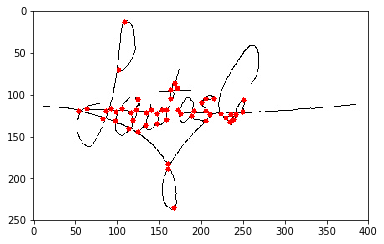

True

In [46]:
# Good Features To Track

import numpy as np
import cv2
from matplotlib import pyplot as plt

img = cv2.imread('./images/threshold2.jpg')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

corners = cv2.goodFeaturesToTrack(gray,500,0.3,5)
corners = np.int0(corners)

for i in corners:
    x,y = i.ravel()
    cv2.circle(img,(x,y),3,255,-1)

plt.imshow(img),plt.show()
cv2.imwrite('./images/corners_1000.jpg',img)

In [42]:
# Obteniendo Features
import cv2
img = cv2.imread('./images/signatures/drsc/legit_1.jpg')
img2 = cv2.imread('./images/signatures/drsc/legit_2.jpg')
img3 = cv2.imread('./images/signatures/drsc/legit_3.jpg')

img = preprocess(img)
img2 = preprocess(img2)
img3 = preprocess(img3)

x_train = [obtenerFeatures(img), obtenerFeatures(img2)
          , obtenerFeatures(img3)]
print x_train

# 5.Feature Scaling
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
x_train = sc_x.fit_transform(x_train)
print x_train

Aspect Ratio :  0.625
Aspect Ratio :  0.625
Aspect Ratio :  0.625
[[0.625, 0.023989796744675683, 0.01789, 46, 1416, 1256, 1375, 2392, 3376, 3565, 5381, 13, 14], [0.625, 0.01814741724818424, 0.017389999999999999, 42, 1032, 933, 996, 4533, 4865, 5298, 7697, 25, 14], [0.625, 0.019450661241098677, 0.01806, 55, 1081, 925, 1054, 4422, 4637, 5015, 7401, 23, 4]]
[[ 0.          1.38192408  0.3868191  -0.30656967  1.40446297  1.41389625
   1.39987122 -1.4127136  -1.3998535  -1.39773709 -1.40443024 -1.3970014
   0.70710678]
 [ 0.         -0.9511819  -1.37144955 -1.04233688 -0.84580315 -0.68100508
  -0.8739196   0.76275019  0.87401762  0.88527741  0.8460267   0.88900089
   0.70710678]
 [ 0.         -0.43074218  0.98463045  1.34890655 -0.55865982 -0.73289118
  -0.52595161  0.64996341  0.52583588  0.51245969  0.55840354  0.50800051
  -1.41421356]]
